In [1]:
library(readxl)
library(timedeppar)

Loading required package: mvtnorm



# Functions

In [2]:
initialize_dataframes <- function(n_years = 30000) {
    cols <- c("Period", "dPeriod", "Amplitude", "dAmplitude", 
              "Phase", "dPhase")
    
    # load dataframes
    stal_harmonics <- read_excel("./data/Borneo Stalagmite 02.04.25.xlsx", 
                           range="N11:S18", col_names=cols)
    
    d18o_harmonics <- read_excel("./data/d18O NGRIP 21.04.24.xlsx", 
                            sheet="Spectra d18O", range="B11:G33", 
                            col_names=cols)
    
    d18o_raw_tot <- read_excel("./data/d18O NGRIP 21.04.24.xlsx", 
                       sheet="Raw Data", range="C11:D6124", 
                       col_names=c("Age", "d18o"))
    
    # center raw d18o data and keep just first N years
    years_from_now <- d18o_raw_tot$Age - d18o_raw_tot$Age[1]
    d18o_raw_tot$Age <- years_from_now
    first30ky <- d18o_raw_tot[years_from_now <= 30000,]
    first30ky["d18o"] <- first30ky$d18o - mean(first30ky$d18o)
    d18o_raw <- first30ky[first30ky$Age <= n_years,]
    
    # add new columns
    d18o_harmonics$Omega <- numeric(nrow(d18o_harmonics))
    d18o_harmonics$dOmega <- numeric(nrow(d18o_harmonics))
    d18o_harmonics$FixedOmega <- rep(FALSE, nrow(d18o_harmonics))
    
    # identify reference omegas
    for (i in 1:nrow(d18o_harmonics)) {
        for (j in 1:nrow(stal_harmonics)) {
            d18o_period <- d18o_harmonics$Period[i]
            stal_period <- stal_harmonics$Period[j]
            
            # calculate relative difference
            rel_diff <- abs(d18o_period - stal_period) / stal_period
            if (rel_diff <= 0.03) {
                d18o_harmonics$FixedOmega[i] <- TRUE
                d18o_harmonics$Period[i] <- stal_harmonics$Period[j]
                d18o_harmonics$dPeriod[i] <- stal_harmonics$dPeriod[j]
            }
        }
    }
    
    # calculate values of Omega and dOmega
    d18o_harmonics$Omega <- 2 * pi / d18o_harmonics$Period
    d18o_harmonics$dOmega <- 2 * pi * d18o_harmonics$dPeriod / d18o_harmonics$Period^2
    
    
    # return all the dataframes
    list(
        stal_harmonics = stal_harmonics,
        d18o_harmonics = d18o_harmonics,
        d18o_raw = d18o_raw
    )
    
}

In [3]:
initialize_params <- function(dfs, sigma_d18o=1, gamma=15) {
    # TODO: change sigma_d18o
    
    harmonics <- dfs$d18o_harmonics
    params_names <- c()
    
    raw <- dfs$d18o_raw
    time_diffs <- diff(raw$Age)
    
    # define parameters properties
    param.ini <- list()
    param.ou.ini <- c()
    param.range <- list()
    param.log <- c()
    
    # add harmonics' free parameters to "param.ini"
    for (i in 1:nrow(harmonics)) {
        names <- paste0(c("Amplitude", "Phase", "Period"), i)
        
        A <- harmonics$Amplitude[i]
        param.ini[[names[1]]] <- A
        param.ini[[names[2]]] <- harmonics$Phase[i]
        if (!harmonics$FixedOmega[i]) {
            param.ini[[names[3]]] <- harmonics$Period[i]
        }
        
        param.range[[names[1]]] <- c(A - harmonics$dAmplitude[i], A + harmonics$dAmplitude[i])
        param.range[[names[2]]] <- c(0, 2*pi)
        if (!harmonics$FixedOmega[i]) {
            param.range[[names[3]]] <- harmonics$Period[i] * c(0.97, 1.03)
        } else {
            names <- paste0(c("Amplitude", "Phase"), i)
        }
        
        params_names <- c(params_names, names)
        
    }
    param.ini$xi <- cbind(
        t = raw$Age[-nrow(raw)],
        y = time_diffs
    )
    param.ini$sigma_d18o <- sigma_d18o
    
    # add xi parameters to "param.ou.ini"
    param.ou.ini <- c( mean(time_diffs), sd(time_diffs), gamma)
    names(param.ou.ini) <- c("xi_mean", "xi_sd", "xi_gamma")
    
    # ranges
    param.range$sigma_d18o = c(0.01, 10)
    param.range$xi_sd = c(0.01, 10) # TODO: change values
    param.range$xi_gamma = c(1, 20)
    
    # for all free parameters set whether to infer in log-space or not
    param.log <- c(rep(FALSE, length(params_names)+3), TRUE)
    names(param.log) <- c(params_names, "xi", "xi_sd", "xi_gamma", "sigma_d18o")
    
    list(
        ini = param.ini,
        ou.ini = param.ou.ini,
        range = param.range,
        log = param.log
    )
}

In [4]:
log_likelihood <- function(params, data) {
    # build the model from current parameters
    model <- build_model(data, params)$y
    
    # feedback
    count <<- count + 1
    current_percent <- as.integer(100 * count / max_count)
    
    if (current_percent > percent) {        
        # draw percent bar
        percent <<- current_percent
        filled <- floor(percent / 2)
        spaces <- max(0, 50 - filled - 1)
        
        bar <- c(rep("█", filled), rep("░", spaces))
        cat(paste0("\r", paste(bar, collapse = ""), 
                   "  ", current_percent, "%"))
        
        flush.console()
    }
    
    # return the log-likelihood of the observed data
    sum(dnorm(data$d18o, mean = model, 
              sd = params$sigma_d18o, log=TRUE))
}

In [5]:
logprior <- function(params) {    
    harmonics <- dataframes$d18o_harmonics
    ix <- 1:nrow(harmonics)
    
    res <- 0
    for (param_name in c("Amplitude", "Period", "Phase")) {
        if (param_name == "Period") {
            ix <- ix[!(harmonics$FixedOmega)]
        }
        
        param0 <- harmonics[[param_name]][ix]
        param <- params[paste0(param_name, ix)]
        dparam <- harmonics[[paste0("d", param_name)]][ix]
        if (param_name == "Phase") {
            dparam <- rep(0.1, length(ix))
        }
        
        res <- res + sum(dnorm(param, mean = param0, 
                               sd = dparam, log = TRUE))
    }
    return(res)
}

In [6]:
run_inference <- function(dfs, params, n.iter=1000, n.interval=25) {    
    percent <<- 0
    count <<- 0
    max_count <<- n.iter * (n.interval + 1)
    
    raw <- dfs$d18o_raw
    
    res <- infer.timedeppar(
        loglikeli = log_likelihood,
        data = raw,
        param.ini = params$ini,
        param.ou.ini = params$ou.ini,
        param.log = params$log,
        param.range = params$range,
        param.logprior = logprior,
        verbose = 0,
        n.iter = n.iter,
        control = list(
            n.interval = n.interval,
            n.adapt = floor(0.4 * n.iter)
        )
    )
    
    plot(res, type = c("traces", "time-series"))
    return(res)
}

In [7]:
build_model <- function(raw, params=NA) {
    harmonics <- dataframes$d18o_harmonics
    
    times <- raw$Age
    if (!sum(is.na(params))) {
        xi <- params$xi[,2]
        times <- c(raw$Age[1], raw$Age[1] + cumsum(xi))
    }
    
    model <- numeric(length(times))
    for (i in 1:nrow(harmonics)) {
        amplitude <- harmonics$Amplitude[i]
        phase <- harmonics$Phase[i]
        omega <- 2 * pi / harmonics$Period[i]
        
        if (!sum(is.na(params))) {
            amplitude <- params[[paste0("Amplitude", i)]]
            phase <- params[[paste0("Phase", i)]]
            if (!harmonics$FixedOmega[i]) {
                omega <- 2 * pi / params[[paste0("Period", i)]]
            }
        }

        model <- model + amplitude * cos(omega * times + phase)
    }
    
    return(list(x=times, y=model))
}

In [8]:
compare_results <- function(res, xlim=NULL) {
    plot(dataframes$d18o_raw, 
         type = "l", lwd = 0.2,
         xlim = xlim
    )
    lines(build_model(dataframes$d18o_raw), 
          col = "red", lwd = 2)
    
    a <- res$sample.param.const
    b <- res$sample.param.timedep
    a["xi"] <- b[nrow(b),]
    lines(build_model(dataframes$d18o_raw,a[nrow(a),]), 
          col = "steelblue", lwd = 2)
}

infer.timedeppar (timedeppar 1.0.3 2023-08-28): starting new Markov Chain

  number of constant parameters:          69

  number of time-dependent parameters:    1

  number of estimated process parameters: 3



█████████████████████████████████████████████████  99%

10000 iterations completed

  acceptance frequency of constant parameters:             0.161

  acceptance frequencies of time-dependent parameters:     0.28

  acceptance frequencies of Ornstein-Uhlenbeck parameters: 0.168

plot.timedeppar (timedeppar 1.0.3 2023-08-28): plotting inference results: traces,time-series



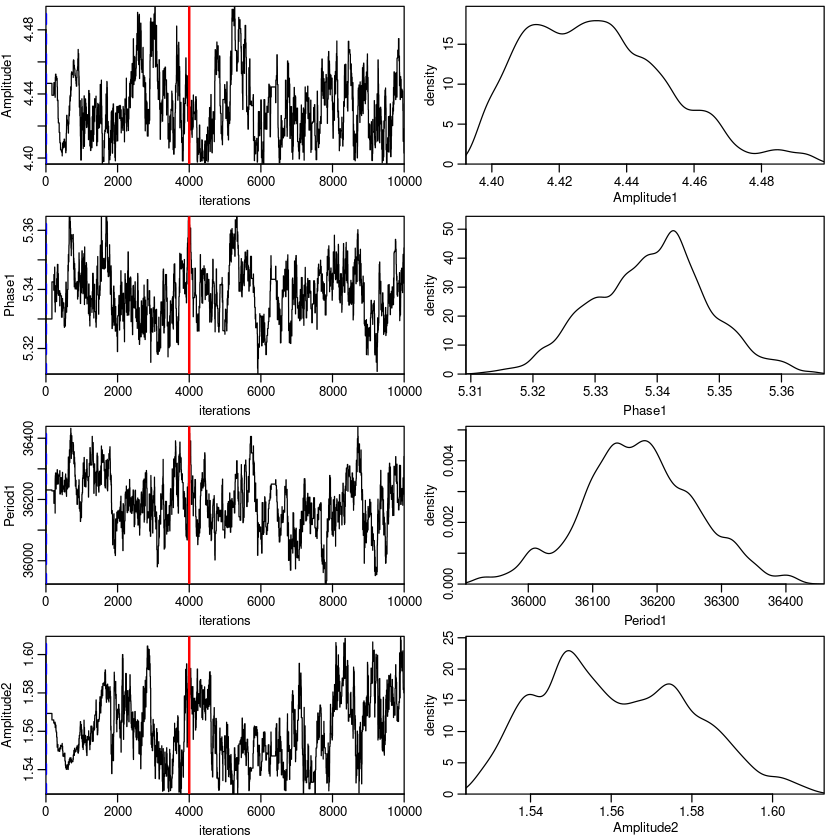

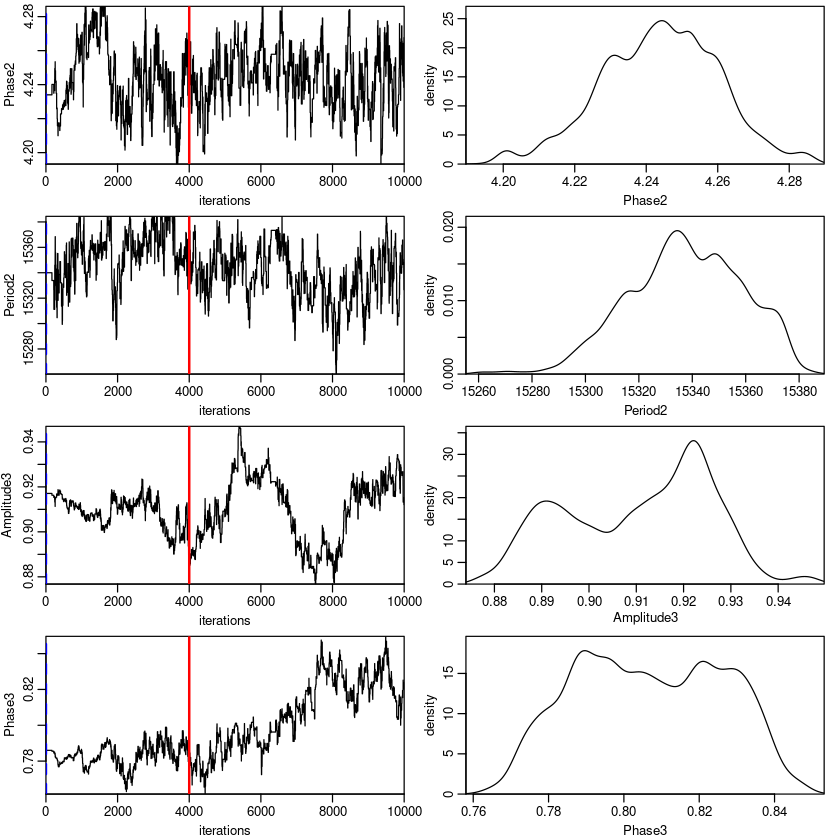

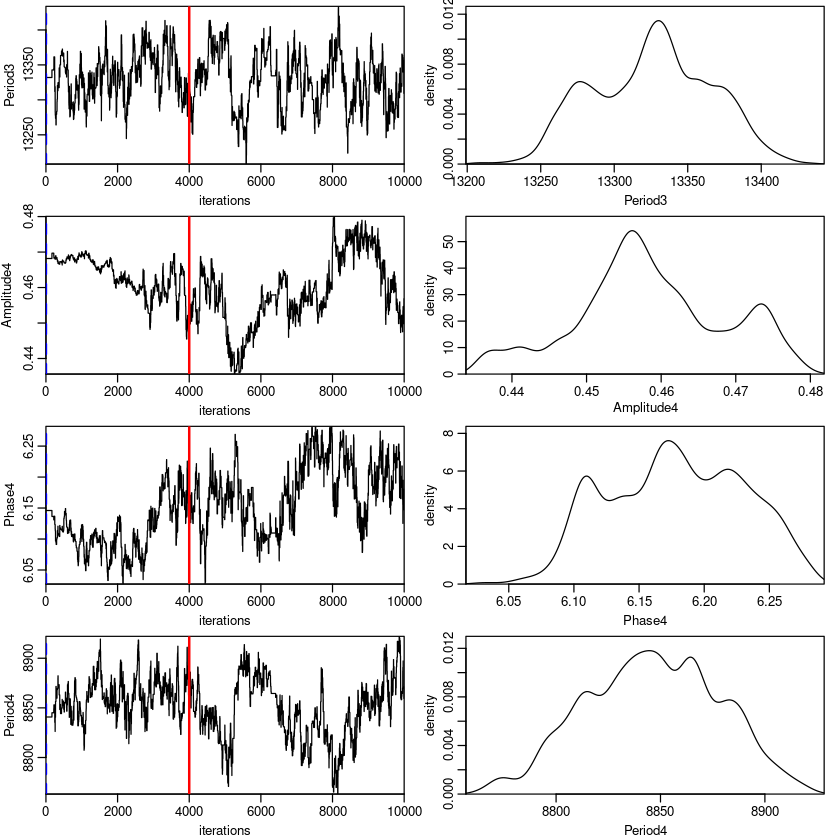

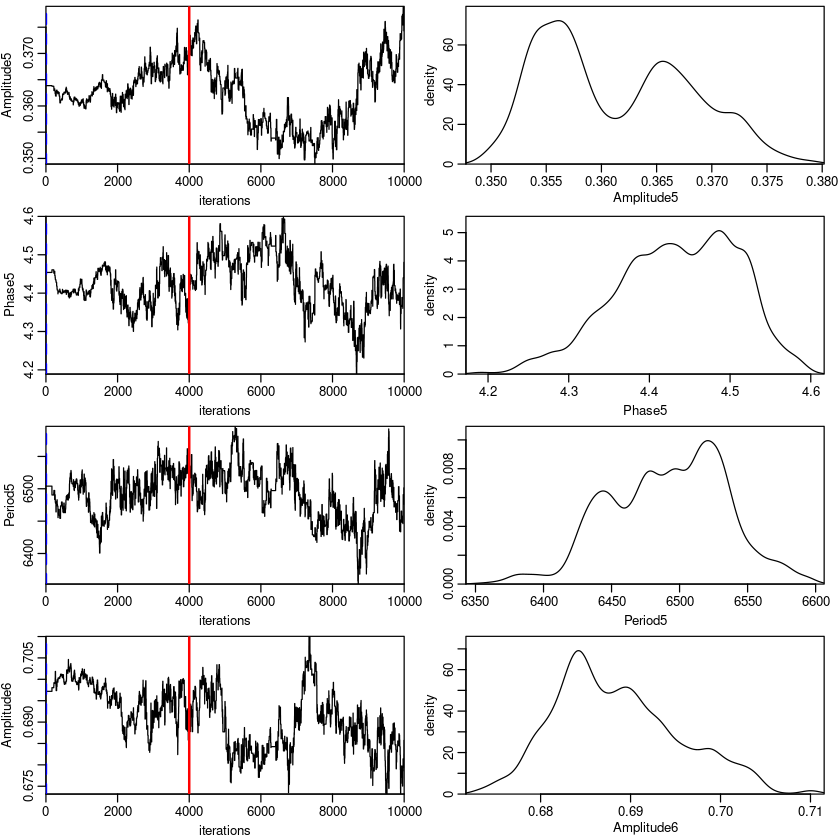

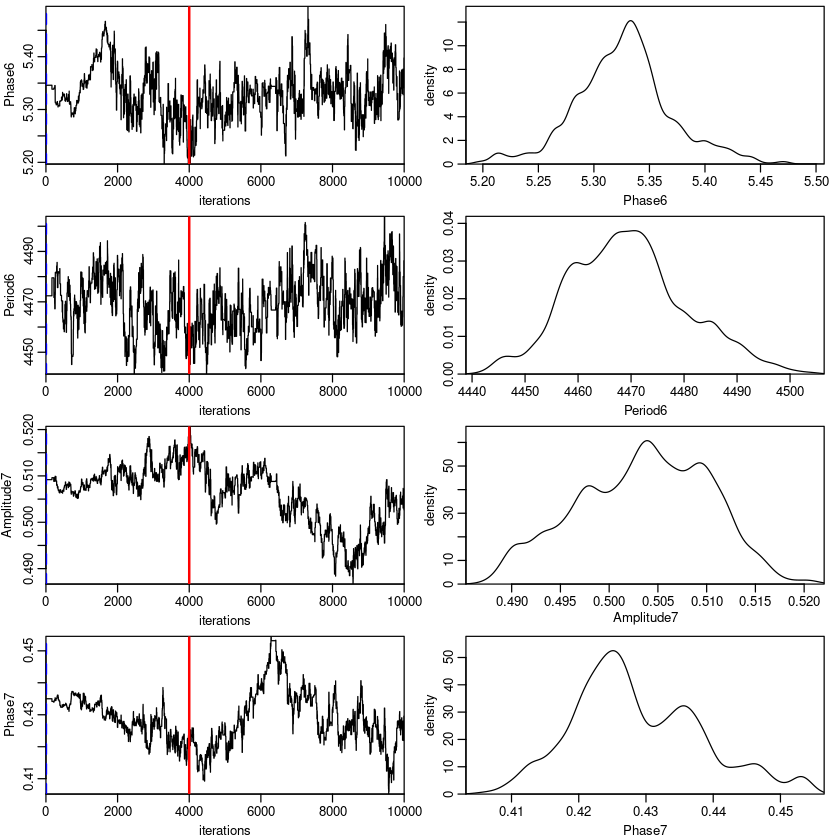

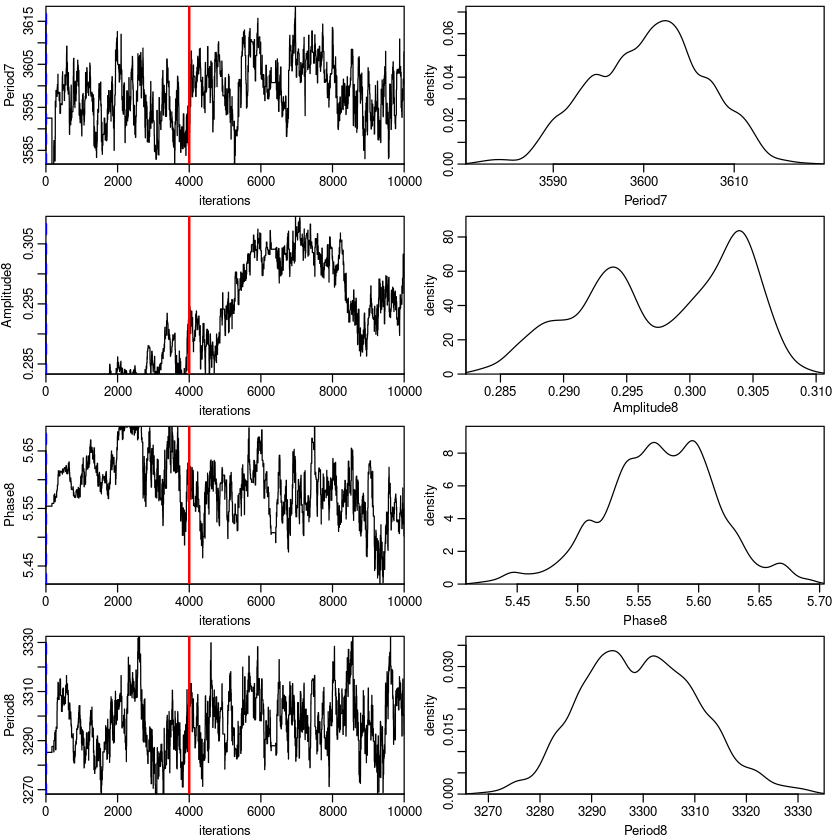

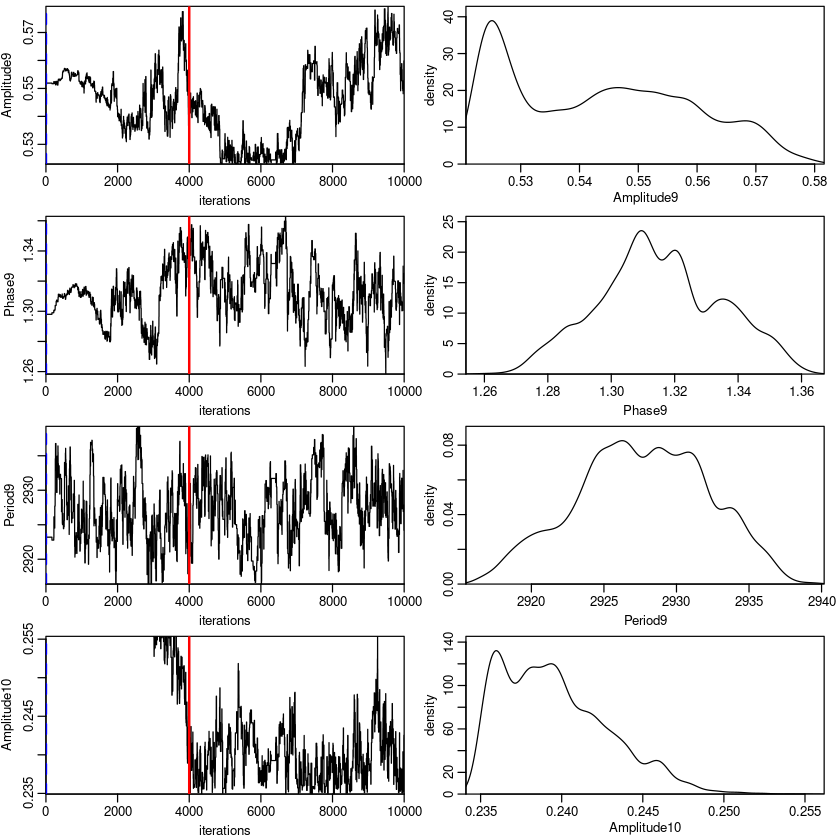

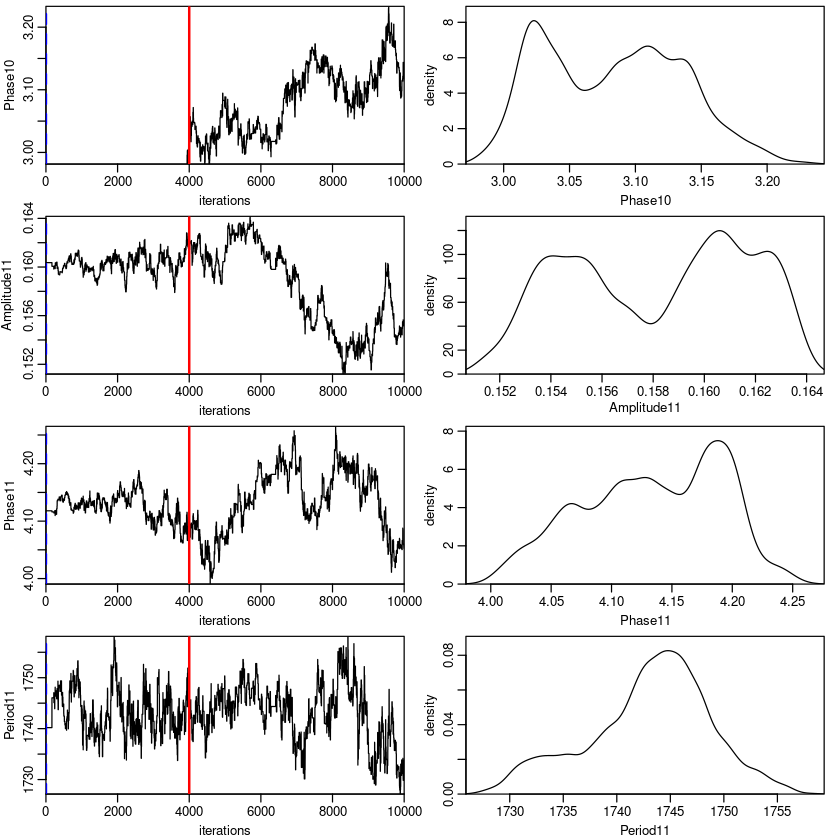

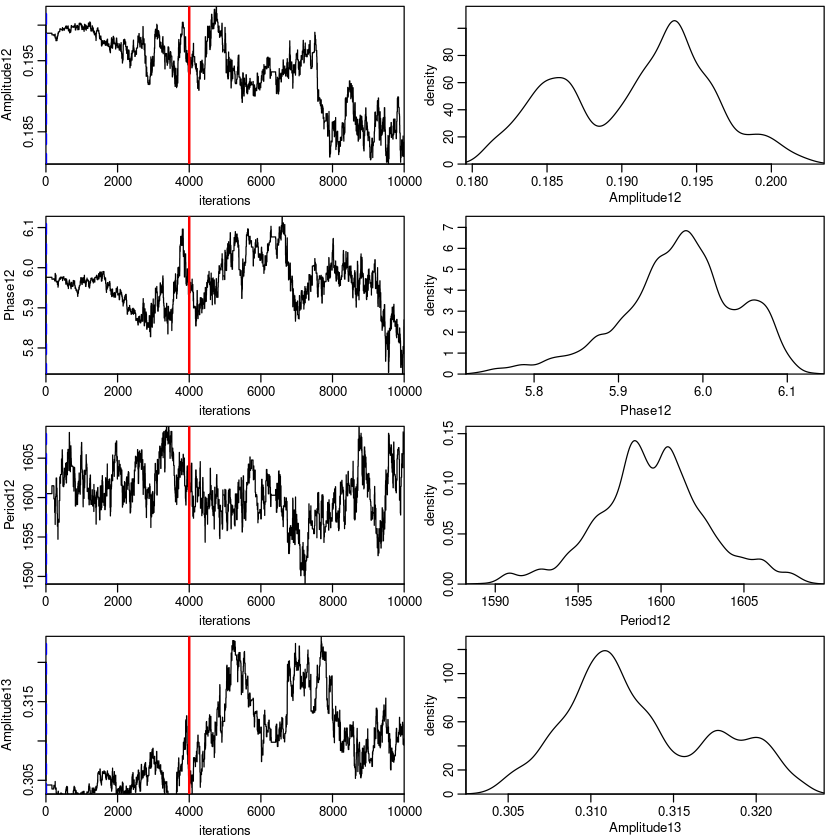

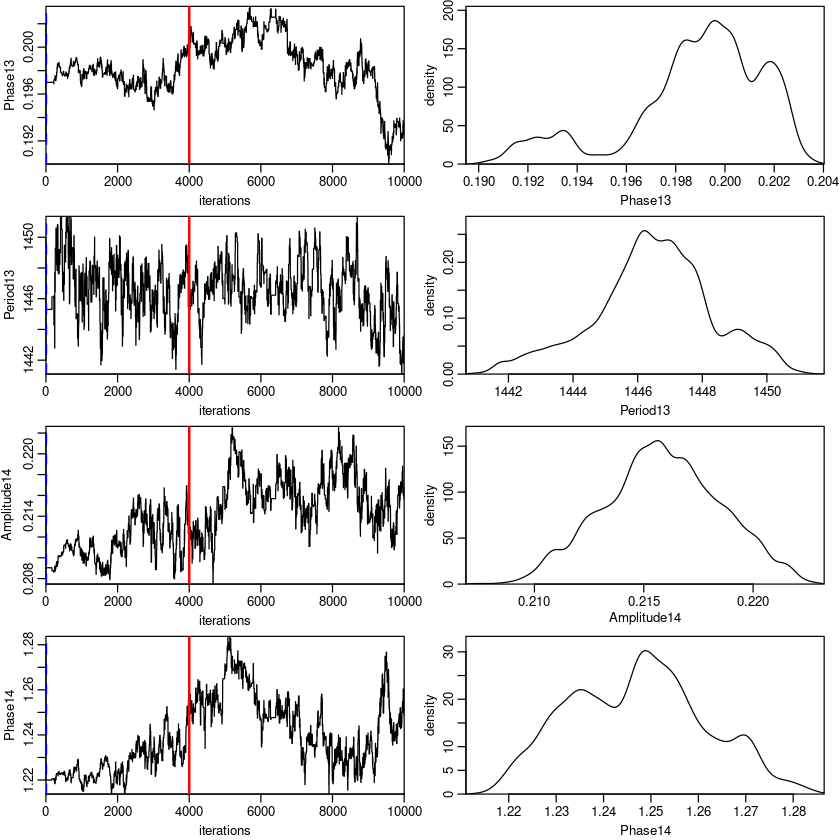

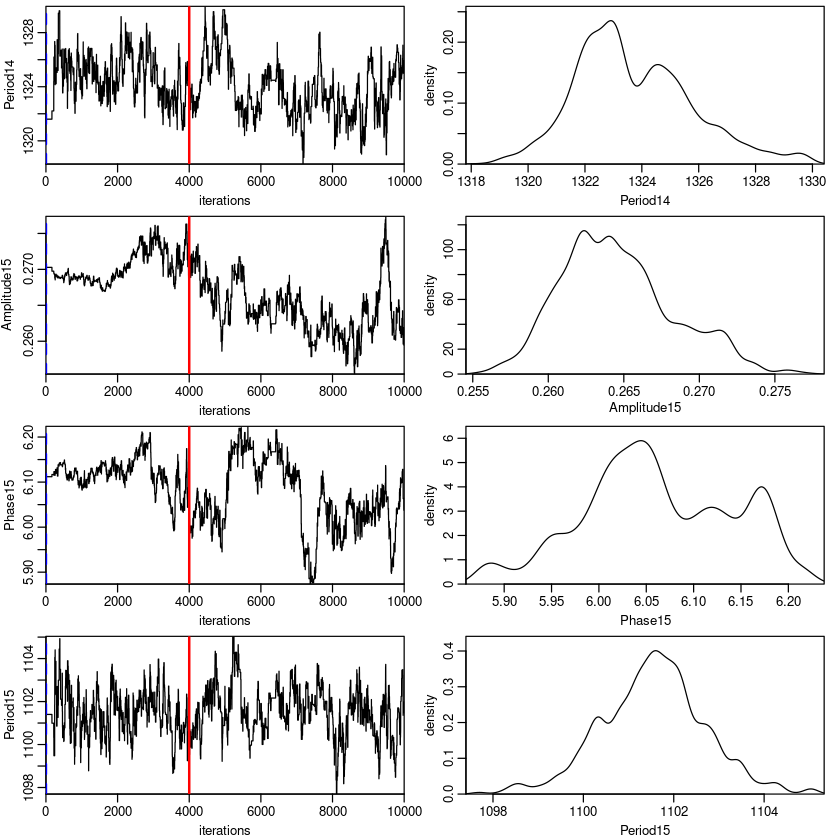

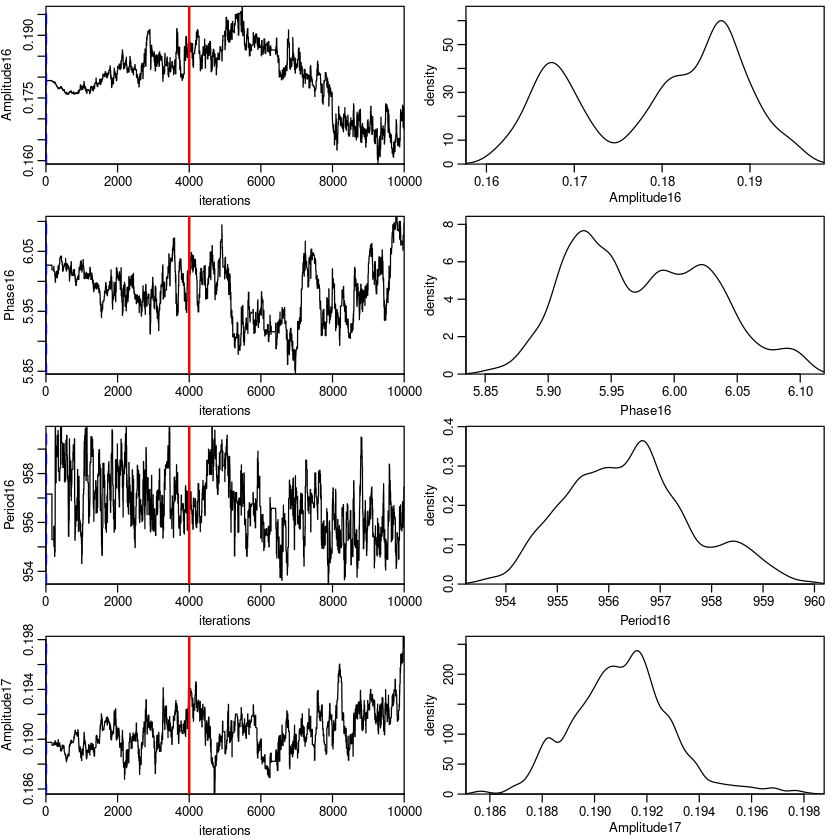

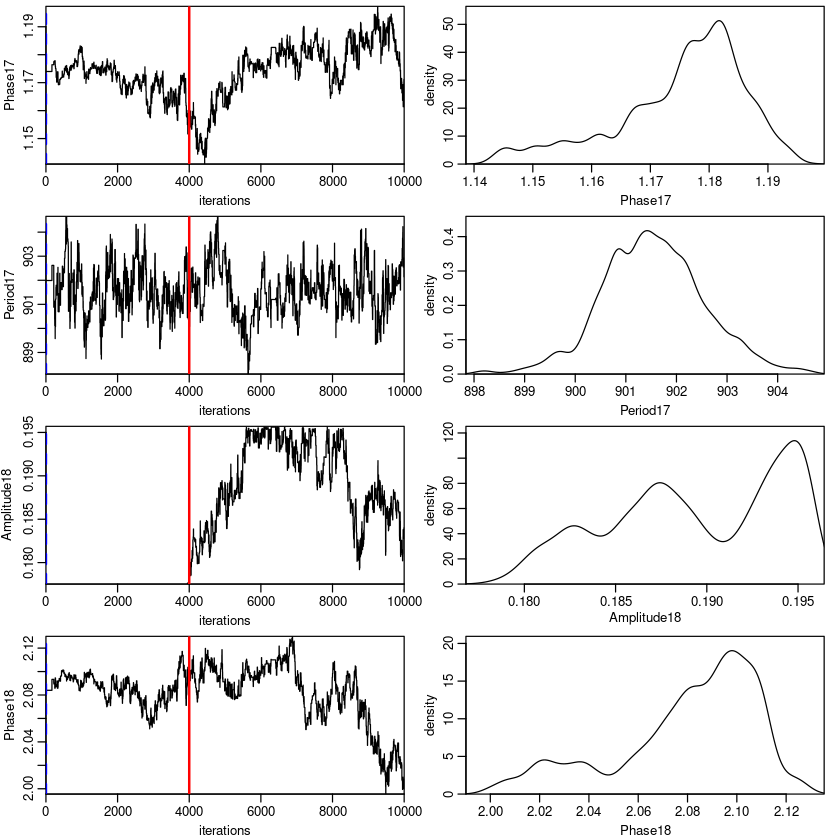

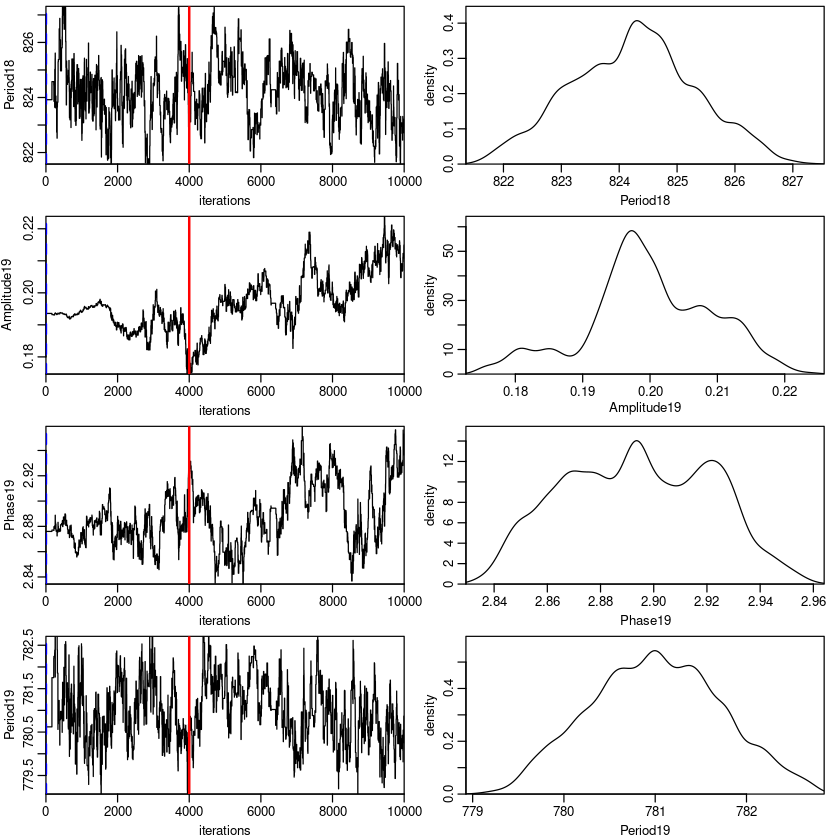

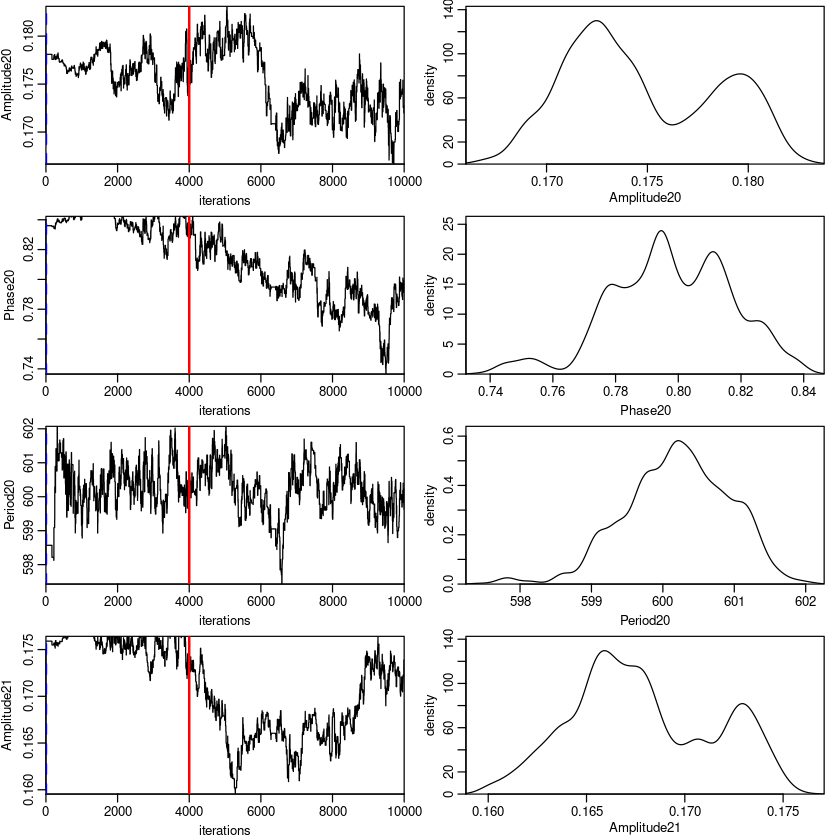

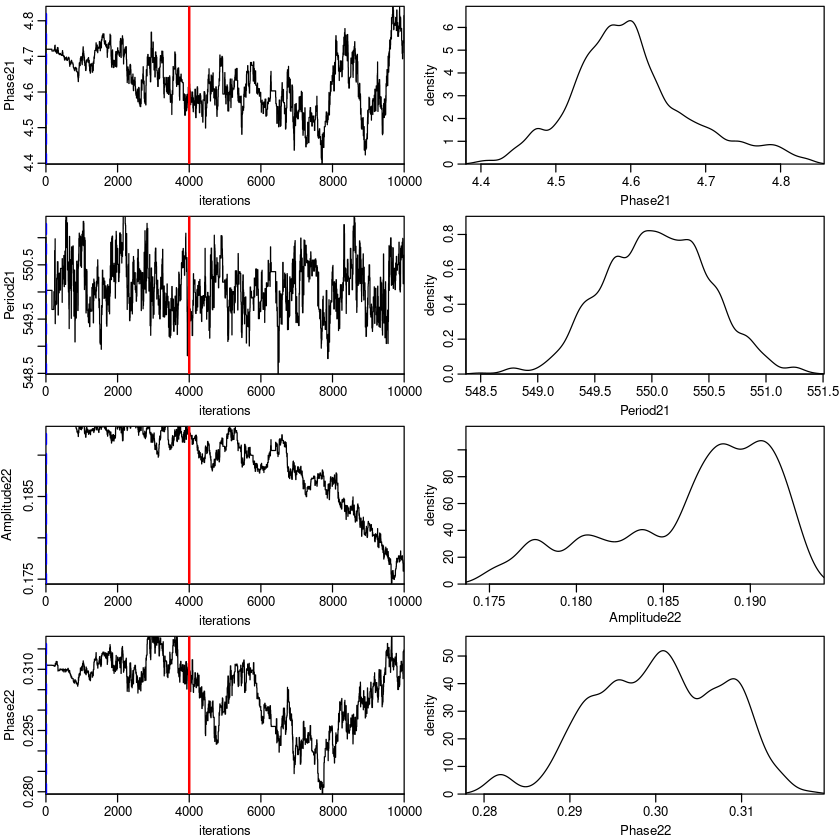

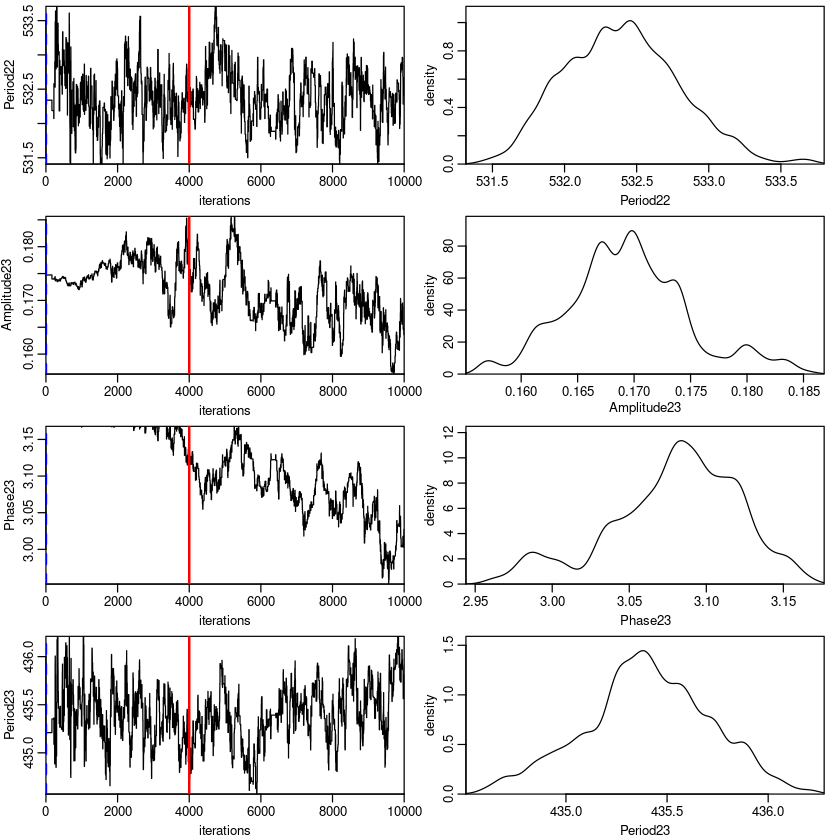

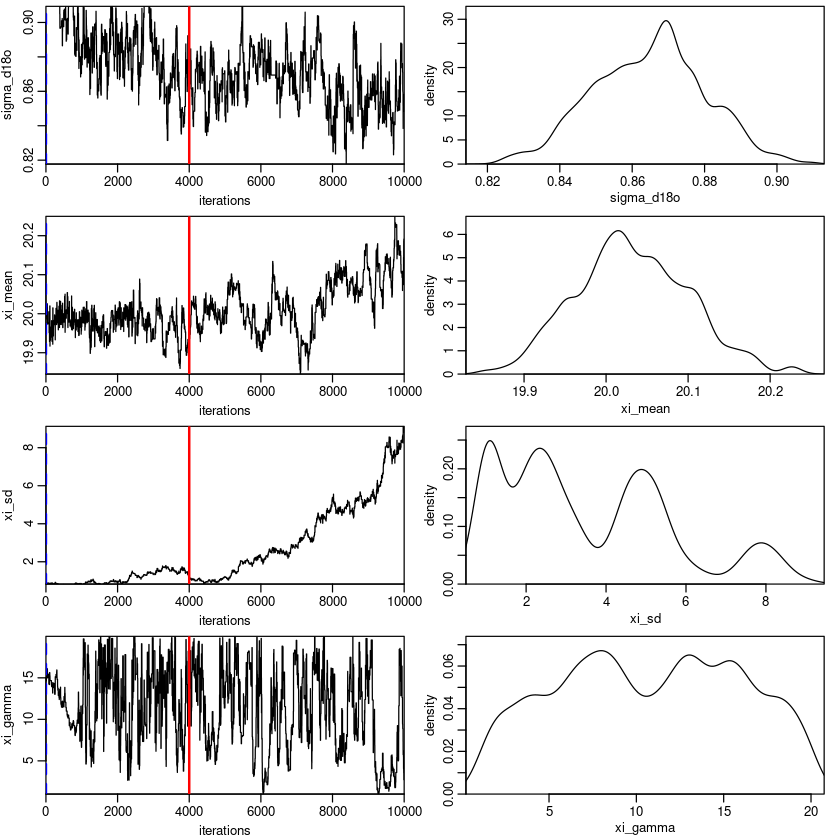

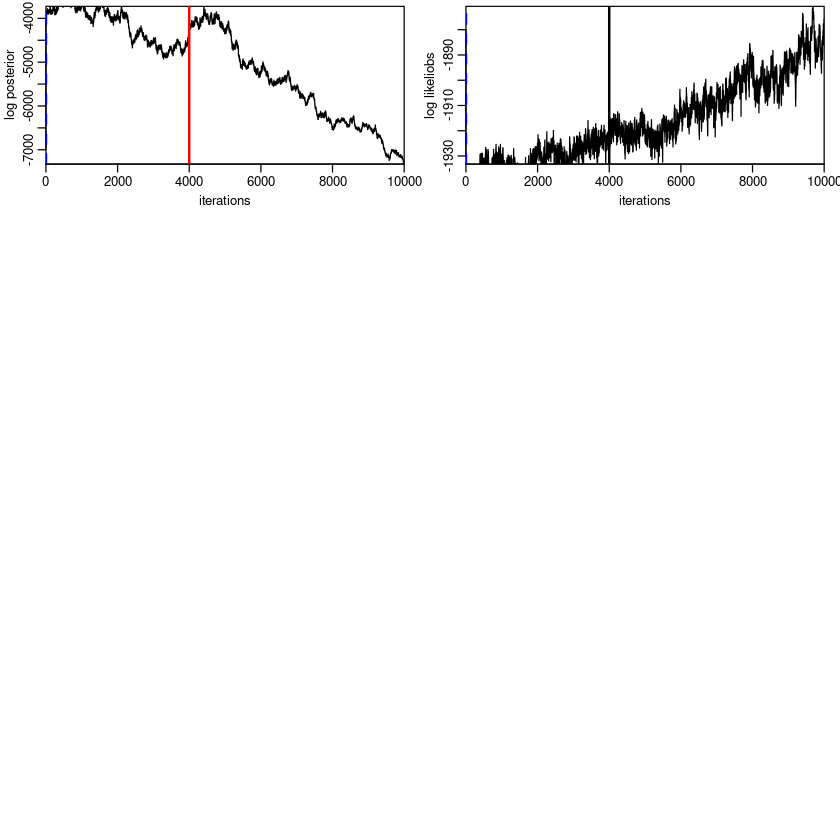

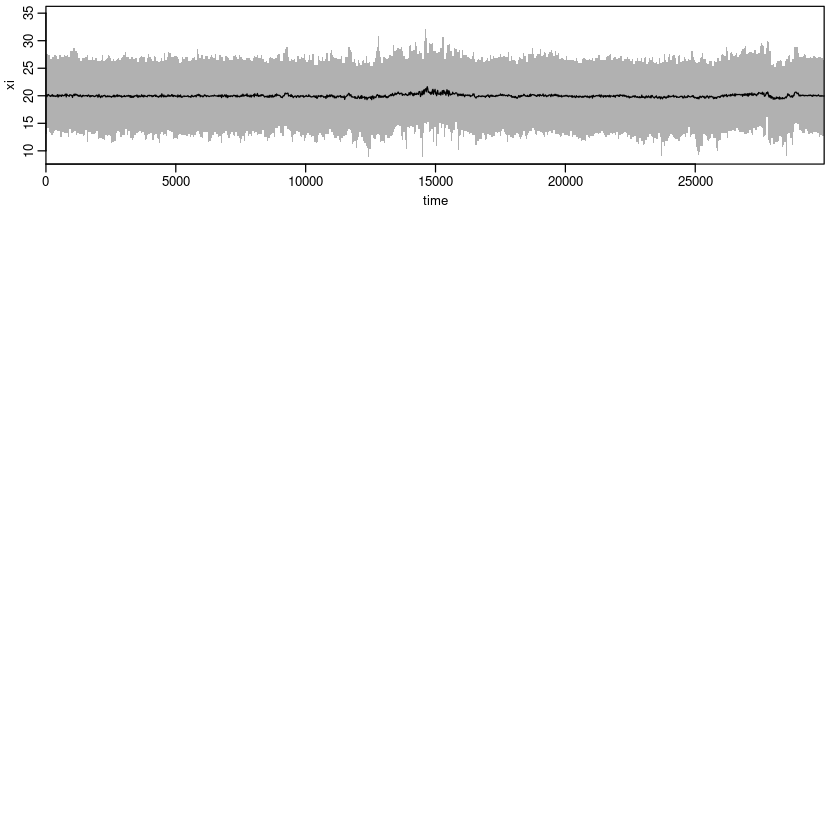

In [13]:
dataframes <- initialize_dataframes()
params <- initialize_params(dataframes)
res <- run_inference(dataframes, params, n.iter=10000)

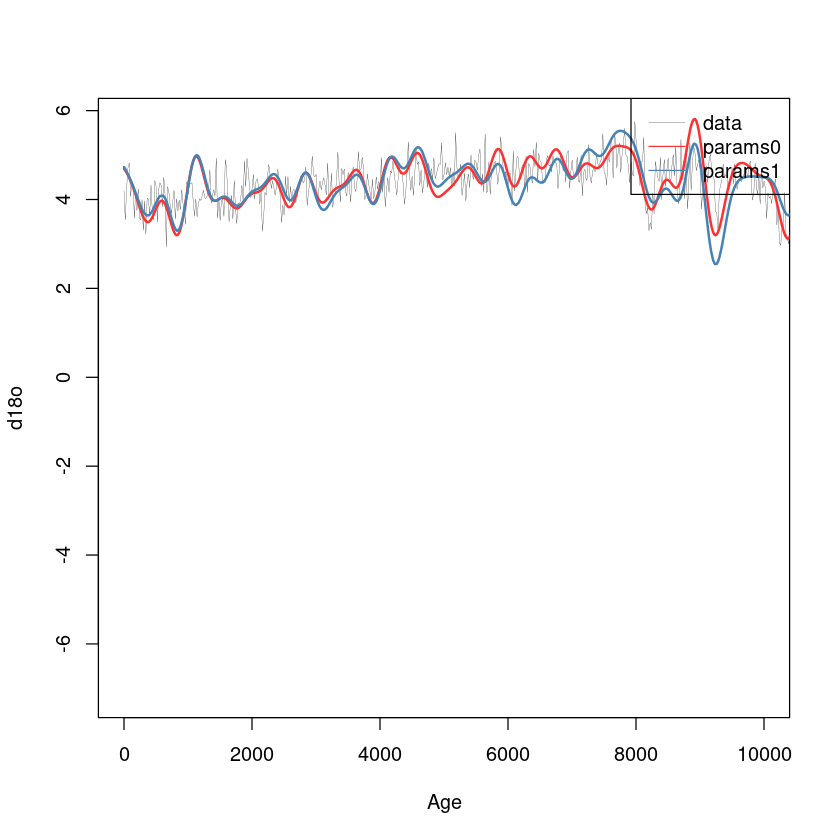

In [33]:
raw <- dataframes$d18o_raw
harmonics <- dataframes$d18o_harmonics

xi <- res$sample.param.timedep$xi
xi <- xi[nrow(xi),]
times <- c(raw$Age[1], raw$Age[1] + cumsum(xi))
params1 <- as.data.frame(res$sample.param.const)
params1 <- params1[nrow(params1),]

model <- numeric(length(times))
for (i in 1:nrow(harmonics)) {
    amplitude <- params1[[paste0("Amplitude", i)]]
    phase <- params1[[paste0("Phase", i)]]
    if (!harmonics$FixedOmega[i]) {
        omega <- 2 * pi / params1[[paste0("Period", i)]]
    }

    model <- model + amplitude * cos(omega * times + phase)
}

plot(dataframes$d18o_raw, 
         type = "l", lwd = 0.2,
         xlim = c(0,10000)
    )
lines(build_model(dataframes$d18o_raw), 
          col = "firebrick1", lwd = 2, lty=1)

lines(list(x=times, y=model), col = "steelblue", lwd = 2)

legend("topright",
       legend=c("data", "params0", "params1"),
       lty=c(1,1,1),
       lwd=c(0.2,1,1),
       col=c(1, "firebrick1", "steelblue")
)

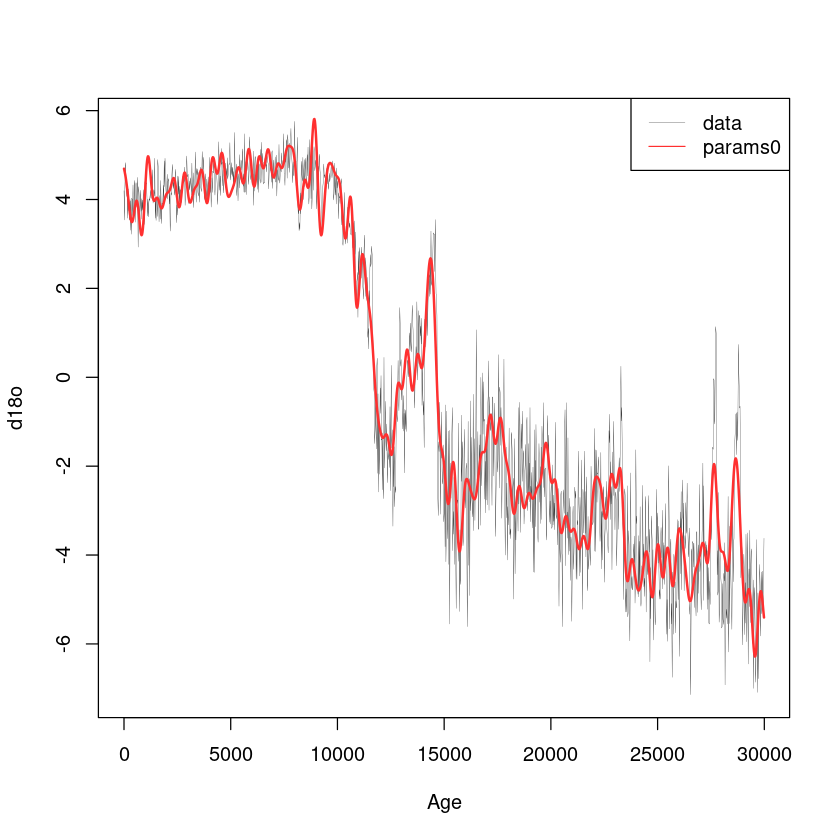

In [32]:
plot(dataframes$d18o_raw, 
         type = "l", lwd = 0.2,
         xlim = NULL
    )
lines(build_model(dataframes$d18o_raw), 
          col = "firebrick1", lwd = 2, lty=1)

legend("topright",
       legend=c("data", "params0"),
       lty=c(1,1),
       lwd=c(0.2,1),
       col=c(1, "firebrick1")
)

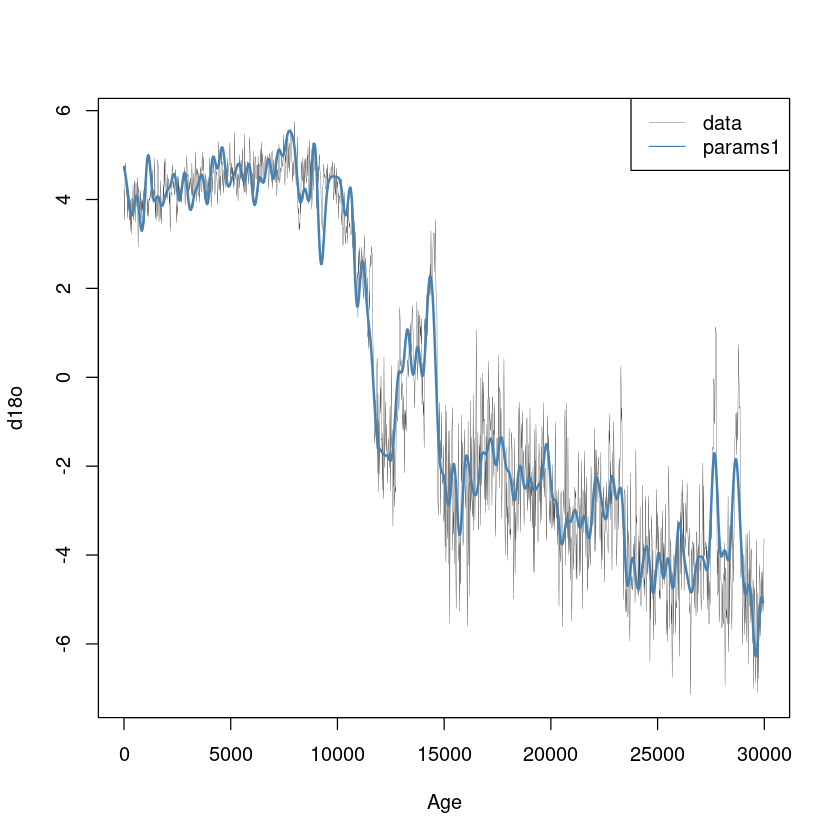

In [31]:
plot(dataframes$d18o_raw, 
         type = "l", lwd = 0.2,
         xlim = NULL
    )

lines(list(x=times, y=model), col = "steelblue", lwd = 2)

legend("topright",
       legend=c("data", "params1"),
       lty=c(1,1),
       lwd=c(0.2,1),
       col=c(1, "steelblue")
)

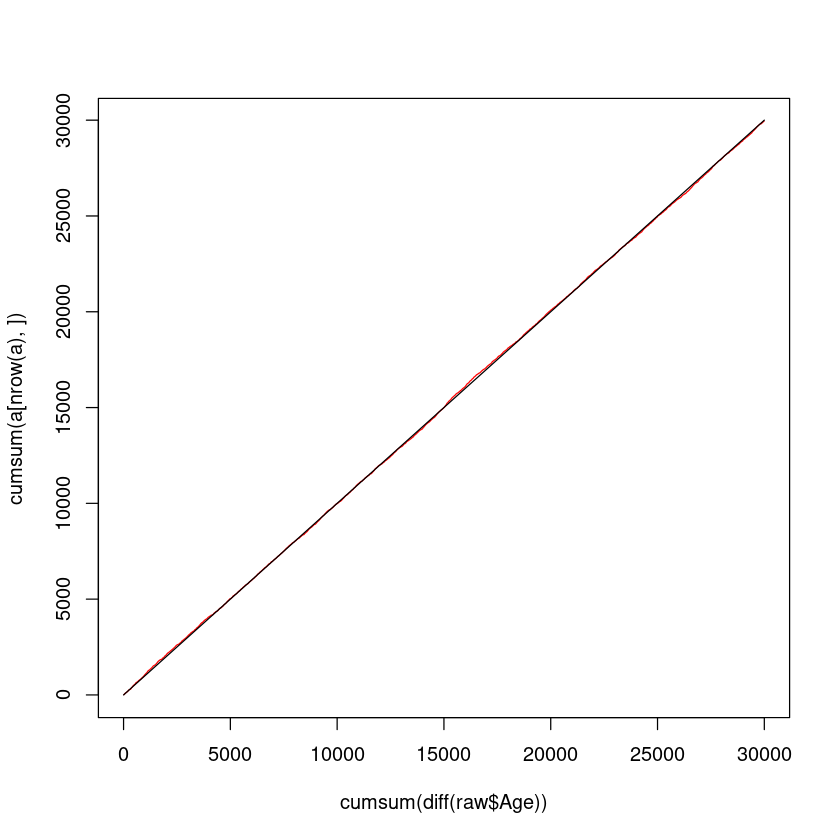

In [41]:
a <- res$sample.param.timedep$xi
plot(cumsum(diff(raw$Age)), cumsum(a[nrow(a),]), type="l", col="red")
lines(1:30000, 1:30000)